# Bayesian linear regression with Pyro

Outline
* how to implement Bayesian Linear regression with Python and PyTorch using Pyro
* how to use MCMC methods for a quick start
* what is stochastic variational inference, and how does it work
* what can we do with the model


Based on: 
1. https://pyro.ai/examples/bayesian_regression.html
2. https://pyro.ai/examples/bayesian_regression_ii.html


In [1]:
from IPython.display import HTML, display, Markdown, Latex

import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt

from torch.distributions import constraints
import pyro
import pyro.distributions as dist

In [2]:
from pyro import optim
from pyro.infer import SVI, Trace_ELBO, Predictive

In [3]:
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [4]:
import matplotlib

# for notebook
%matplotlib inline 

# for lab
#%matplotlib widget
plt.style.use('default')

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['mathtext.fontset']='cm'
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

# Data

Dataset is taken from ['Ruggedness: The blessing of bad geography in Africa'](https://diegopuga.org/data/rugged/) by Nathan Nunn and Diego Puga, in Review of Economics and Statistics 94(1), February 2012: 20-36.

We will use the data to study the relationship between a country's GDP and its geography.

In [5]:
data_url = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(data_url, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [6]:
data.describe()

,isonum,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,lon,soil,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,2.300000e+02,234.000000,234.000000,225.000000,...,234.000000,234.000000,234.000000,2.340000e+02,57.000000,57.000000,57.000000,57.000000,2.010000e+02,165.000000
mean,431.461538,1.375402,0.821585,3.942355,0.393329,19.643829,5.736381e+04,17.226902,12.903197,38.165564,...,0.068376,0.068376,0.042735,6.696709e+04,7.463842,6.761982,3.570263,3.458281,1.754828e+06,32.361224
std,252.967641,1.370052,0.916172,4.006825,0.385709,23.016250,1.711326e+05,25.085770,75.096558,27.717410,...,0.252931,0.252931,0.202693,3.216307e+05,3.314207,4.296534,1.610134,1.534231,8.001854e+06,41.754401
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,-51.745000,-177.194000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,3.541000,0.032000,0.310000,0.064000,0.000000e+00,0.000000
25%,212.500000,0.376000,0.268750,1.126750,0.104250,0.819750,3.037500e+02,0.844750,-53.196000,15.820000,...,0.000000,0.000000,0.000000,0.000000e+00,4.932000,2.623000,2.642000,2.293000,3.608200e+04,0.000000
50%,429.000000,0.961500,0.576000,2.689500,0.283000,11.771000,8.252750e+03,16.111000,17.667500,34.264000,...,0.000000,0.000000,0.000000,0.000000e+00,5.712000,7.643000,3.359000,3.529000,2.396930e+05,2.200000
75%,642.750000,1.981000,1.032250,5.628500,0.581500,32.667500,4.070725e+04,38.280250,49.827000,56.646000,...,0.000000,0.000000,0.000000,0.000000e+00,10.108000,9.457000,4.846000,4.571000,9.815910e+05,80.600000
max,894.000000,7.811000,6.722000,21.453000,2.106000,100.000000,1.638134e+06,78.845000,178.052000,100.000000,...,1.000000,1.000000,1.000000,3.610000e+06,16.393000,16.775000,6.637000,6.465000,8.094376e+07,100.000000


Preview data:

In [7]:
data.head()

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
0,ABW,533,Aruba,0.462,0.380,1.226,0.144,0.000,18.0,12.508,...,0,0,0,0.0,NaN,NaN,NaN,NaN,614.0,NaN
1,AFG,4,Afghanistan,2.518,1.469,7.414,0.720,39.004,65209.0,33.833,...,0,0,0,0.0,NaN,NaN,NaN,NaN,1870829.0,0.0
2,AGO,24,Angola,0.858,0.714,2.274,0.228,4.906,124670.0,-12.299,...,0,0,1,3610000.0,5.669,6.981,4.926,3.872,1223208.0,2.0
3,AIA,660,Anguilla,0.013,0.010,0.026,0.006,0.000,9.0,18.231,...,0,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,ALB,8,Albania,3.427,1.597,10.451,1.006,62.133,2740.0,41.143,...,0,0,0,0.0,NaN,NaN,NaN,NaN,200000.0,100.0


Сравним визуально африканские и неафриканские страны.

In [8]:
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

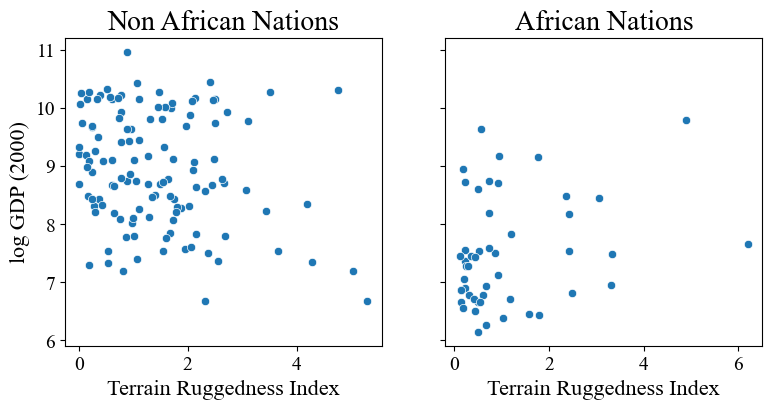

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

Introduce additional feature: product of `cont_africa` and `rugged`:

In [10]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data_np = df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values
data_t = torch.tensor(data_np,
                      dtype=torch.float)

is_cont_africa, ruggedness, log_gdp = data_t[:, 0], data_t[:, 1], data_t[:, 3]

# MCMC and SVI for Bayesian inference

Similar to coin-tossing example, we define a function that describes our model. We pass features separately and assume independent standard normal prioirs on each parameter.

In [11]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
    return mean

#### MCMC for approximate Bayesian inference

In [12]:
from pyro.infer import MCMC, NUTS
from pyro.infer.mcmc.util import predictive as mcmc_predictive

In [13]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(is_cont_africa, ruggedness, log_gdp)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|███████████████████████████████████████| 1200/1200 [00:30, 39.36it/s, step size=4.20e-01, acc. prob=0.920]


In [14]:
print(f"all keys: {hmc_samples.keys()}")
sites = ["a", "bA", "bR", "bAR", "sigma"]
hmc_dict = {k: hmc_samples[k] for k in sites}
hmc_df = pd.DataFrame(hmc_dict)
hmc_df['Method'] = 'MCMC'

all keys: dict_keys(['a', 'bA', 'bAR', 'bR', 'sigma'])


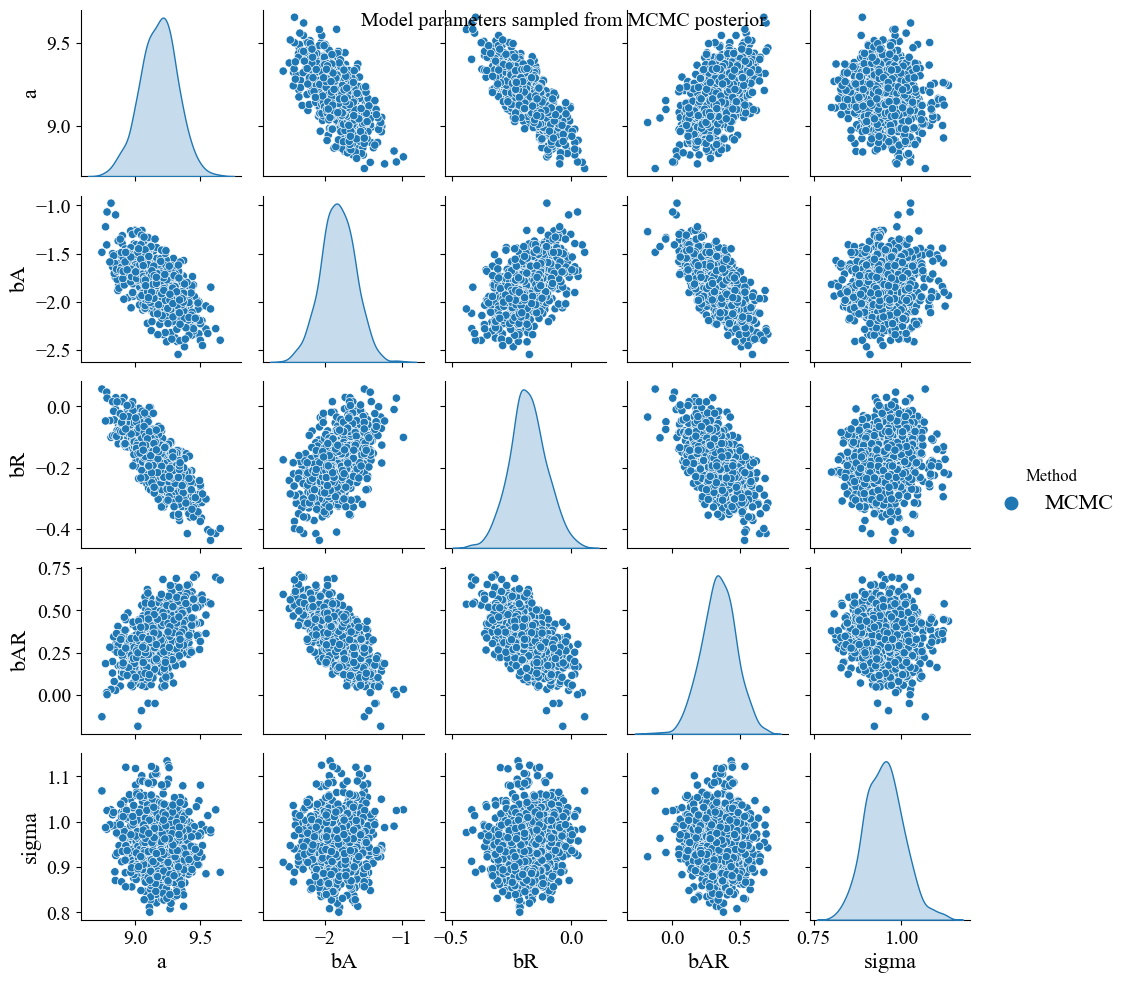

In [15]:
sns.pairplot(hmc_df, hue='Method', height=2)
plt.suptitle("Model parameters sampled from MCMC posterior")
plt.show()

We can see that MCMC approach prived a posterior estimate where some parameters are highly dependent. Also we can oserve that noise was indeed sampled independently from the parameters.

However, the computational complexity and limited ways to parallelize computations may render this approach unusable for large datasets and/or models.

#### Next, we will consider approximate variational inference

For Stochastic Variational Inference in Pyro we need the following:

* `model` - our generative model of the data, constructed using Pyro primitives (already have)
* `guide` - family of distributions, among which to search for the approximate posterior (*variational family*)

Our approximate posterior will consist of independent normals for each parameter:

In [16]:
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))

In [17]:
svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

pyro.clear_param_store()
num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if (i + 1) % 500 == 0:
        print("[iteration {:} / {:}] ELBO loss: {:.7}".format(i + 1, num_iters, elbo))

[iteration 500 / 5000] ELBO loss: 466.7884
[iteration 1000 / 5000] ELBO loss: 296.9588
[iteration 1500 / 5000] ELBO loss: 247.1635
[iteration 2000 / 5000] ELBO loss: 248.246
[iteration 2500 / 5000] ELBO loss: 248.3616
[iteration 3000 / 5000] ELBO loss: 248.812
[iteration 3500 / 5000] ELBO loss: 249.5489
[iteration 4000 / 5000] ELBO loss: 249.7655
[iteration 4500 / 5000] ELBO loss: 247.2588
[iteration 5000 / 5000] ELBO loss: 247.6984


In [18]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
               if k != "obs"}

In [19]:
svi_dict = {k: svi_samples[k] for k in sites}
svi_df = pd.DataFrame(svi_dict)
svi_df['Method'] = 'SVI'

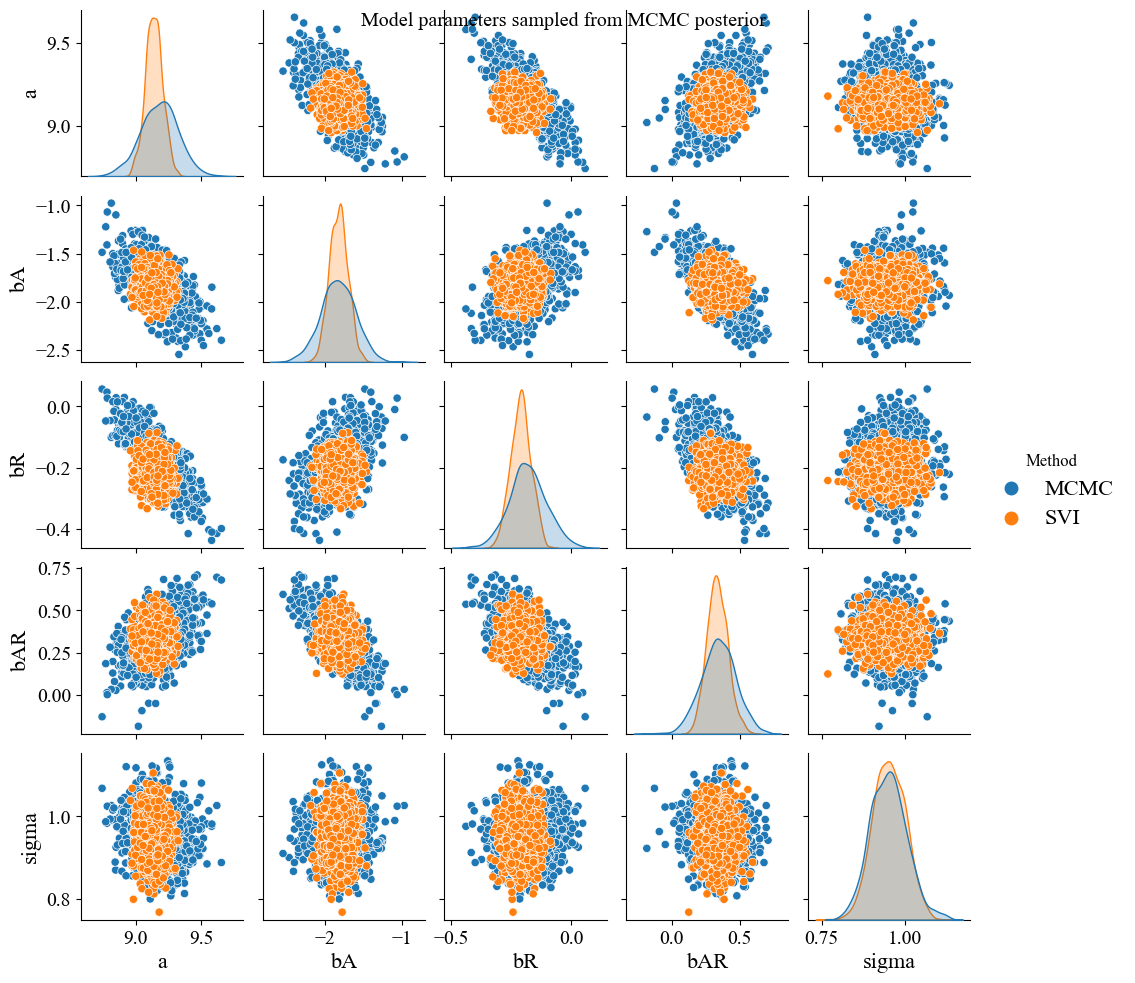

In [20]:
sns.pairplot(pd.concat([hmc_df, svi_df], ignore_index=True), hue='Method', height=2)
plt.suptitle("Model parameters sampled from MCMC posterior")
plt.show()

In [21]:
svi_mean = svi_df['a'].values.T + data_np[:, :-1] @ svi_df[['bA', 'bR', 'bAR']].values.T
print(svi_mean.shape)
svi_df_pred = df.copy()
svi_df_pred['mean'] = svi_mean.mean(axis=1)
svi_df_pred['mean_lo'] = np.quantile(svi_mean, 0.05, axis=1)
svi_df_pred['mean_hi'] = np.quantile(svi_mean, 0.95, axis=1)

(170, 1000)


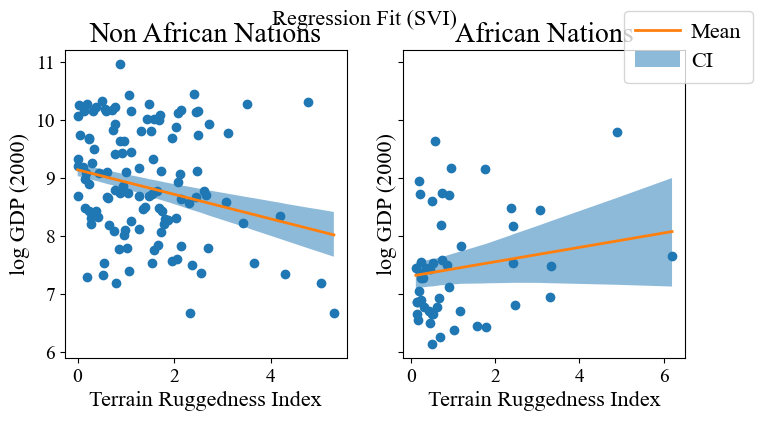

In [22]:
african_nations = svi_df_pred.query('cont_africa == 1')
non_african_nations = svi_df_pred.query('cont_africa == 0')
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)

fig.suptitle("Regression Fit (SVI)", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2, label='Mean')
ax[0].fill_between(non_african_nations["rugged"], 
                   non_african_nations["mean_hi"], 
                   non_african_nations["mean_lo"], alpha=0.5, label='CI')
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].fill_between(african_nations["rugged"], 
                   african_nations["mean_hi"], 
                   african_nations["mean_lo"], alpha=0.5)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")
fig.legend()

# Pyro modules

Instead of putting everything into a one big function, we can define the model similar to how we define a neural network in PyTorch.

**PyroModule** - a subclass of **torch.nn.Module**. It is similar to the regular Pytorch module: it will define a trainable transformation, but in this case the parameters can be handled by Pyro in a Bayesian fashion.

In [23]:
from torch import nn
from pyro.nn import PyroModule

In [24]:
# https://github.com/pyro-ppl/pyro/blob/dev/pyro/nn/module.py

print(issubclass(PyroModule[nn.Linear], nn.Linear))
print(issubclass(PyroModule[nn.Linear], PyroModule))

True
True


## Linear regression model

To define a regression model a single linear layer is enough. In our data we have 3 independet variables and one dependent, so:

In [25]:
linear_regression_model = PyroModule[nn.Linear](3, 1)

In [26]:
linear_regression_model

PyroLinear(in_features=3, out_features=1, bias=True)

In [27]:
list(linear_regression_model.named_parameters())

[('weight',
  Parameter containing:
  tensor([[-0.0615, -0.1536, -0.0545]], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0.2570], requires_grad=True))]

First we will train the model in the usual way: optimize the squared loss.

In [28]:
loss_function = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_regression_model.parameters(), lr=0.05)

num_iterations = 1500

x_data, y_data = data_t[:, :-1], data_t[:, -1]

In [29]:
def train_step():
    # run the model forward on the data
    y_pred = linear_regression_model(x_data).squeeze(-1)

    # calculate the mse loss
    loss = loss_function(y_pred, y_data)

    # initialize gradients to zero
    optim.zero_grad()

    # backpropagate
    loss.backward()

    # take a gradient step
    optim.step()

    return loss

In [30]:
for j in range(num_iterations):
    loss = train_step()
    if (j + 1) % 50 == 0:
        print("[iteration {:} / {:}] ELBO loss: {:.7}".format(j + 1, num_iterations, loss.item()))

[iteration 50 / 1500] ELBO loss: 3180.063
[iteration 100 / 1500] ELBO loss: 1636.07
[iteration 150 / 1500] ELBO loss: 1110.891
[iteration 200 / 1500] ELBO loss: 827.8871
[iteration 250 / 1500] ELBO loss: 631.7099
[iteration 300 / 1500] ELBO loss: 483.9905
[iteration 350 / 1500] ELBO loss: 373.6476
[iteration 400 / 1500] ELBO loss: 294.2845
[iteration 450 / 1500] ELBO loss: 239.5547
[iteration 500 / 1500] ELBO loss: 203.3277
[iteration 550 / 1500] ELBO loss: 180.279
[iteration 600 / 1500] ELBO loss: 166.1698
[iteration 650 / 1500] ELBO loss: 157.8544
[iteration 700 / 1500] ELBO loss: 153.1342
[iteration 750 / 1500] ELBO loss: 150.5529
[iteration 800 / 1500] ELBO loss: 149.1929
[iteration 850 / 1500] ELBO loss: 148.5027
[iteration 900 / 1500] ELBO loss: 148.1653
[iteration 950 / 1500] ELBO loss: 148.0065
[iteration 1000 / 1500] ELBO loss: 147.9345
[iteration 1050 / 1500] ELBO loss: 147.9032
[iteration 1100 / 1500] ELBO loss: 147.89
[iteration 1150 / 1500] ELBO loss: 147.8847
[iteration 1

We can examine our trained parameters:

In [31]:
print("Learned parameters:")
for name, param in linear_regression_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
weight [[-1.9478561  -0.20278597  0.39330173]]
bias [9.223079]


In [32]:
data_with_predictions = df.copy()
data_with_predictions["mean"] = linear_regression_model(x_data).detach().cpu().numpy()

african_nations = data_with_predictions[data_with_predictions["cont_africa"] == 1]
non_african_nations = data_with_predictions[data_with_predictions["cont_africa"] == 0]

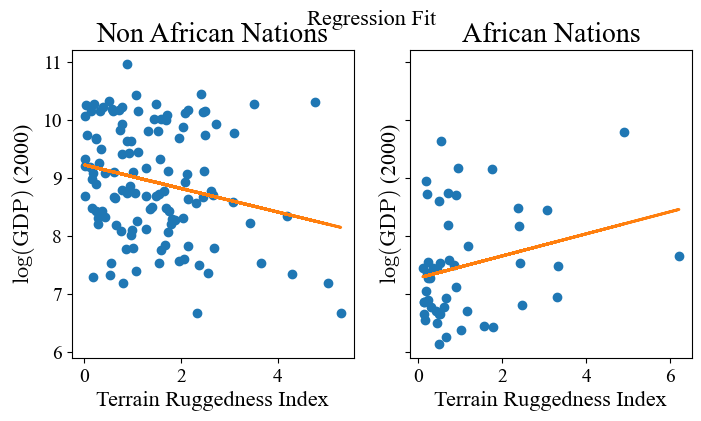

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)

fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel=r"$\log(\mathrm{GDP})$ (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel=r"$\log(\mathrm{GDP})$ (2000)",
          title="African Nations");

## Go Bayesian

In [34]:
from pyro.nn import PyroSample

## Broadcasting in Pyro like a pro

You can define dependent and independent random variables in Pyro.

In [35]:
example_distribution = pyro.distributions.Normal(0.5, 1)
assert example_distribution.batch_shape == ()
assert example_distribution.event_shape == ()
print(example_distribution)

Normal(loc: 0.5, scale: 1.0)


In [36]:
example_random_variable = example_distribution.sample()
assert example_random_variable.shape == ()
assert example_distribution.log_prob(example_random_variable).shape == ()
print(example_random_variable, example_distribution.log_prob(example_random_variable))

tensor(0.9755) tensor(-1.0320)


A separate set of batch dimensions can be defined and they will play nicely with batch dimensions of other entities.

In [37]:
example_distribution = pyro.distributions.Normal(0.5 * torch.ones(3, 4), torch.ones(3, 4))
assert example_distribution.batch_shape == (3, 4)
assert example_distribution.event_shape == ()
print(example_distribution)

Normal(loc: torch.Size([3, 4]), scale: torch.Size([3, 4]))


In [38]:
example_random_variable = example_distribution.sample()
assert example_random_variable.shape == (3, 4)
assert example_distribution.log_prob(example_random_variable).shape == (3, 4)

print("Sampled points:")
print(example_random_variable)
print("Log probabilities for them:")
print(example_distribution.log_prob(example_random_variable))

Sampled points:
tensor([[-9.3871e-04,  1.0964e+00,  1.3232e+00,  1.7370e-02],
        [-7.2112e-01,  5.4461e-01, -8.1450e-02,  1.5119e+00],
        [ 5.1195e-01,  1.2305e+00,  4.5200e-01, -8.0168e-01]])
Log probabilities for them:
tensor([[-1.0444, -1.0968, -1.2577, -1.0354],
        [-1.6645, -0.9199, -1.0880, -1.4309],
        [-0.9190, -1.1858, -0.9201, -1.7661]])


In [39]:
example_distribution = pyro.distributions.MultivariateNormal(0.5 * torch.ones(3, 2), torch.eye(2, 2))
assert example_distribution.batch_shape == (3,)
assert example_distribution.event_shape == (2,)
print(example_distribution)

MultivariateNormal(loc: torch.Size([3, 2]), covariance_matrix: torch.Size([3, 2, 2]))


In [40]:
example_random_variable = example_distribution.sample()
assert example_random_variable.shape == (3, 2)            # == batch_shape + event_shape
assert example_distribution.log_prob(example_random_variable).shape == (3,)  # == batch_shape

`.expand()` - another way to introduce batch dimensions.

In [41]:
example_distribution = pyro.distributions.Bernoulli(torch.tensor([0.1, 0.2, 0.3, 0.4])).expand([3, 4])
assert example_distribution.batch_shape == (3, 4)
assert example_distribution.event_shape == ()
print(example_distribution)

example_random_variable = example_distribution.sample()
assert example_random_variable.shape == (3, 4)
assert example_distribution.log_prob(example_random_variable).shape == (3, 4)
print(example_random_variable)

Bernoulli(probs: torch.Size([3, 4]))
tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])


`.to_event()` is similar to reshaping.

In [42]:
number_of_dependent_dimensions = 1
example_distribution = pyro.distributions.Bernoulli(0.5 * torch.ones(3, 4)).to_event(number_of_dependent_dimensions)
print(example_distribution)
assert example_distribution.batch_shape == (3,)
assert example_distribution.event_shape == (4,)

example_random_variable = example_distribution.sample()
print(example_random_variable)
assert example_random_variable.shape == (3, 4)
assert example_distribution.log_prob(example_random_variable).shape == (3,)

Independent(Bernoulli(probs: torch.Size([3, 4])), 1)
tensor([[1., 1., 0., 1.],
        [1., 1., 0., 1.],
        [0., 1., 1., 0.]])


Conditional independence:

In [43]:
location = 2
scale = 3
with pyro.plate('data', 6):
    observation = pyro.sample('obs', dist.Normal(location, scale))
    print(observation)

tensor([-1.9998,  7.1701,  5.0577, -2.7451, -0.6719,  1.2167])


## Bayesina linear regression

In [44]:
weight_prior = dist.Normal(0., 1.).expand([1, 3]).to_event(2)
print(weight_prior)
print(f"{weight_prior.batch_shape=}, {weight_prior.event_shape=}")
weight_prior.sample()

Independent(Normal(loc: torch.Size([1, 3]), scale: torch.Size([1, 3])), 2)
weight_prior.batch_shape=torch.Size([]), weight_prior.event_shape=torch.Size([1, 3])


tensor([[1.6759, 1.5018, 0.8056]])

In [45]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)

        # PyroSample - create a Pyro-trainable parameter with a predefined prior distribution. Another way - PyroParam
        # expand - duplicates our 1d distribution to the reeqired shape, to_event - will treat parameters as dependent (although they are not in our simple case)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        # pyro.sample will produce stochastic output
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        # linear layer is applied, but the parameters are sampled each time
        mean = self.linear(x).squeeze(-1)
        # pyro.plate will tell pyro that our observations are conditionally independent
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [46]:
model = BayesianRegression(3, 1)

In [47]:
model.linear

PyroLinear(in_features=3, out_features=1, bias=True)

In [48]:
model.linear.weight

tensor([[ 0.0335,  1.4573, -1.2233]])

In [49]:
model.linear.bias

tensor([12.9595])

In [50]:
from pyro.infer.autoguide import AutoDiagonalNormal

Posterior over all model parameters (weights + bias + sigma) will be Multivariate Normal distribution with diaginal covariance matrix. In total we will have 5 parameters.

A parameter will be created automatically for each `sample` statement.

In [51]:
guide = AutoDiagonalNormal(model)
list(guide.named_pyro_params())

[]

In [52]:
adam_optimizer = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam_optimizer, loss=Trace_ELBO())

In [53]:
pyro.clear_param_store()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.8603
[iteration 0101] loss: 2.2805
[iteration 0201] loss: 2.0939
[iteration 0301] loss: 1.8286
[iteration 0401] loss: 1.4265
[iteration 0501] loss: 1.0564
[iteration 0601] loss: 1.0689
[iteration 0701] loss: 1.0614
[iteration 0801] loss: 1.0658
[iteration 0901] loss: 1.0619
[iteration 1001] loss: 1.0594
[iteration 1101] loss: 1.0732
[iteration 1201] loss: 1.0603
[iteration 1301] loss: 1.0630
[iteration 1401] loss: 1.0610


Now we can examine the trained posterior approximation:

In [54]:
list(guide.named_pyro_params())

[('loc',
  Parameter containing:
  tensor([-2.2365, -1.8890, -0.1904,  0.3344,  9.1545], requires_grad=True)),
 ('scale',
  tensor([0.0560, 0.1293, 0.0439, 0.0933, 0.0572], grad_fn=<SoftplusBackward0>))]

In [55]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2365, -1.8890, -0.1904,  0.3344,  9.1545])
AutoDiagonalNormal.scale tensor([0.0560, 0.1293, 0.0439, 0.0933, 0.0572])


In [56]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9327, 0.9652, 0.9987]),
 'linear.weight': tensor([[[-1.9762, -0.2201,  0.2715]],
 
         [[-1.8890, -0.1904,  0.3344]],
 
         [[-1.8018, -0.1608,  0.3974]]]),
 'linear.bias': tensor([[9.1159],
         [9.1545],
         [9.1931]])}

Examine how well our model performs:

In [57]:
def summary(samples):
    """
    Summary for sampled parameters
    """
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [58]:
predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "linear.bias", "sigma", "obs", "_RETURN"))

In [59]:
samples = predictive(x_data)
pred_summary = summary(samples)

In [60]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]

In [61]:
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

In [62]:
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

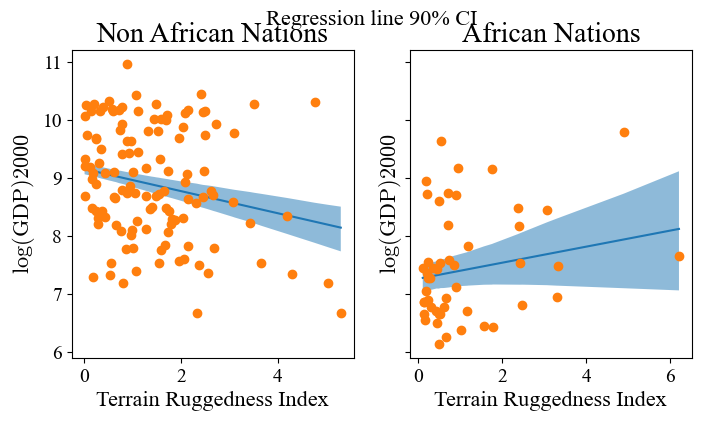

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)

fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel=r"$\log(\mathrm{GDP}) 2000$",
          title="Non African Nations")

ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel=r"$\log(\mathrm{GDP}) 2000$",
          title="African Nations");

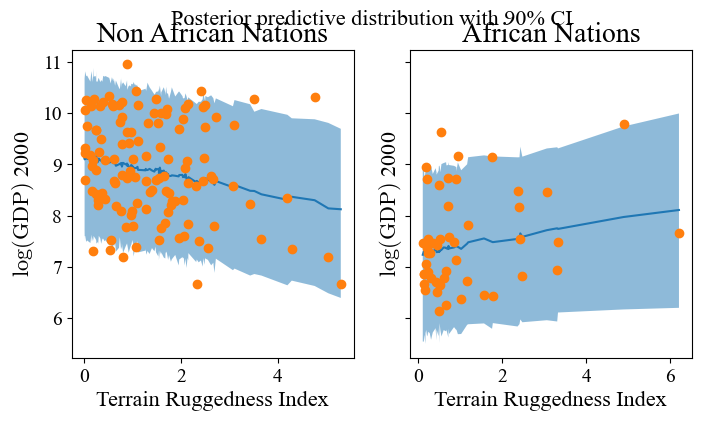

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel=r"$\log(\mathrm{GDP})$ 2000",
          title="Non African Nations")

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel=r"$\log(\mathrm{GDP})$ 2000",
          title="African Nations");

In [65]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

C:\Users\Alex\anaconda3\envs\pyro\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Alex\anaconda3\envs\pyro\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


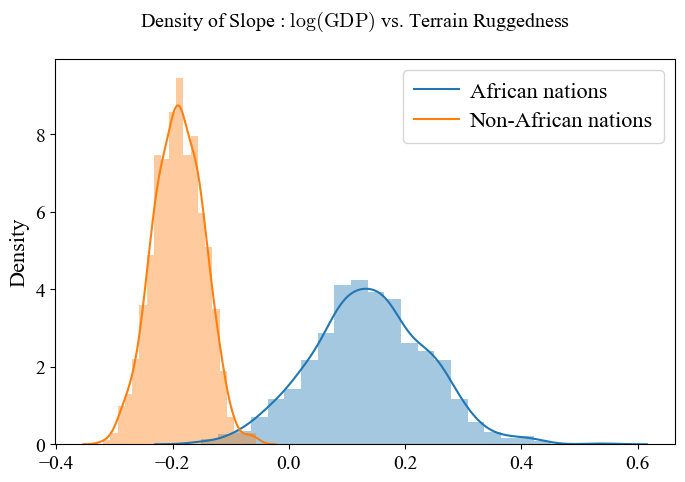

In [71]:
fig = plt.figure(figsize=(8, 5))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle(r"Density of Slope : $\log(\mathrm{GDP})$ vs. Terrain Ruggedness");
plt.legend()

TypeError: __init__() got an unexpected keyword argument 'label'

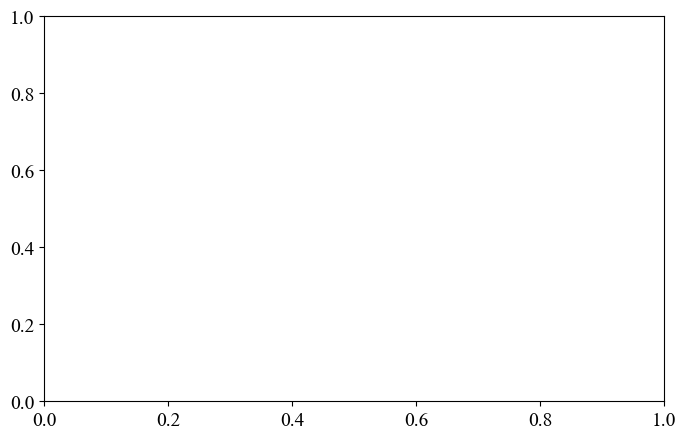

In [72]:
fig = plt.figure(figsize=(8, 5))
sns.histplot(gamma_within_africa, kde=True, kde_kws={"label": "African nations"},)
sns.histplot(gamma_outside_africa, kde=True, kde_kws={"label": "Non-African nations"})
fig.suptitle(r"Density of Slope : $\log(\mathrm{GDP})$ vs. Terrain Ruggedness");
plt.legend()

C:\Users\Alex\anaconda3\envs\pyro\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Alex\anaconda3\envs\pyro\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Alex\anaconda3\envs\pyro\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

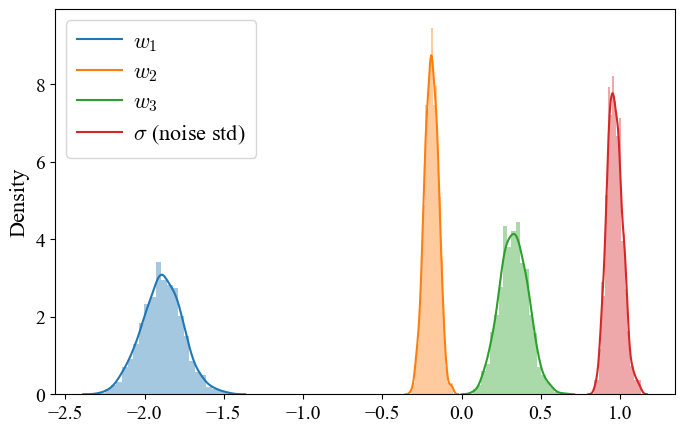

In [67]:
fig = plt.figure(figsize=(8, 5))

bias_samples = samples["linear.bias"]
sigma_samples = samples["sigma"]
for i in range(weight.shape[1]):
    sns.distplot(weight[:, i], kde_kws={"label": fr"$w_{i + 1}$"},)
#sns.distplot(bias_samples, kde_kws={"label": r"$w_0$ (bias)"},)
sns.distplot(sigma_samples, kde_kws={"label": r"$\sigma$ (noise std)"},)
plt.legend()

Bonus: models can be exported to C++, to avoid using Python on inference.